In [36]:
import os
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent.parent
sys.path.append(str(parent_dir))
import re
import instruments as inst
from instruments_jax import *
from physical_models import *
from scipy import stats as scipy_stats
import h5py
import corner
import shutil
import tqdm
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    "lines.linewidth": 3,
})
import json


In [41]:
def plot_corner_flat(chain, param_names, step_range=(0, None), median_or_max="median", num_bins=100):
    flat_chain = chain[step_range[0]:step_range[1], :, :].reshape(-1, chain.shape[-1])
    converted_chain = flat_chain.copy()

    for i, name in enumerate(param_names):
        if ".phi" in name:
            converted_chain[:, i] = converted_chain[:, i] / (2 * np.pi)

    if median_or_max == "median":
        truths = np.median(converted_chain, axis=0)
    elif median_or_max == "max":
        truths = []
        for i in range(converted_chain.shape[1]):
            hist, bin_edges = np.histogram(converted_chain[:, i], bins=num_bins)
            max_index = np.argmax(hist)
            max_val = (bin_edges[max_index] + bin_edges[max_index + 1]) / 2
            truths.append(max_val)
        truths = np.array(truths)
    else:
        raise ValueError("median_or_max must be 'median' or 'max'")
 
    fig = corner.corner(
        converted_chain,
        labels = [name.replace("delta_theta", "offset").replace("image_rotator", "imr") for name in param_names],
        truths=truths,
        plot_datapoints=False, label_kwargs={"fontsize":3}   # disables individual scatter points
    )

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12)
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        ax.xaxis.labelpad = 40
        ax.yaxis.labelpad = 40

    plt.tick_params(axis='x', which='both', pad=5)
    plt.tick_params(axis='y', which='both', pad=5)
    return fig,ax

def load_chain_and_labels(h5_filename, txt_filename, include_logf=False):
    base, ext = os.path.splitext(h5_filename)
    h5_copy = base + "_copy" + ext
    shutil.copy(h5_filename, h5_copy)

    with h5py.File(h5_copy, 'r') as f:
        chain = f['mcmc']['chain'][:]

    with open(txt_filename, 'r') as f:
        p0_dict = json.load(f)

    param_names = [f"{comp}.{param}" for comp, params in p0_dict.items() for param in params]
    if include_logf:
        param_names.append("log_f")

    return chain, param_names
p0_dict = {
    "image_rotator" : 
        {"d": 1, "delta_theta": 2},
    "hwp" :  
        {"w_SiO2": 3, "w_MgF2": 4, "delta_theta": 5},
    "lprot" : 
        {"pa": 6},
}
with open('mcmcp0.json','w') as f:
    json.dump(p0_dict,f)

(40001, 24, 7)


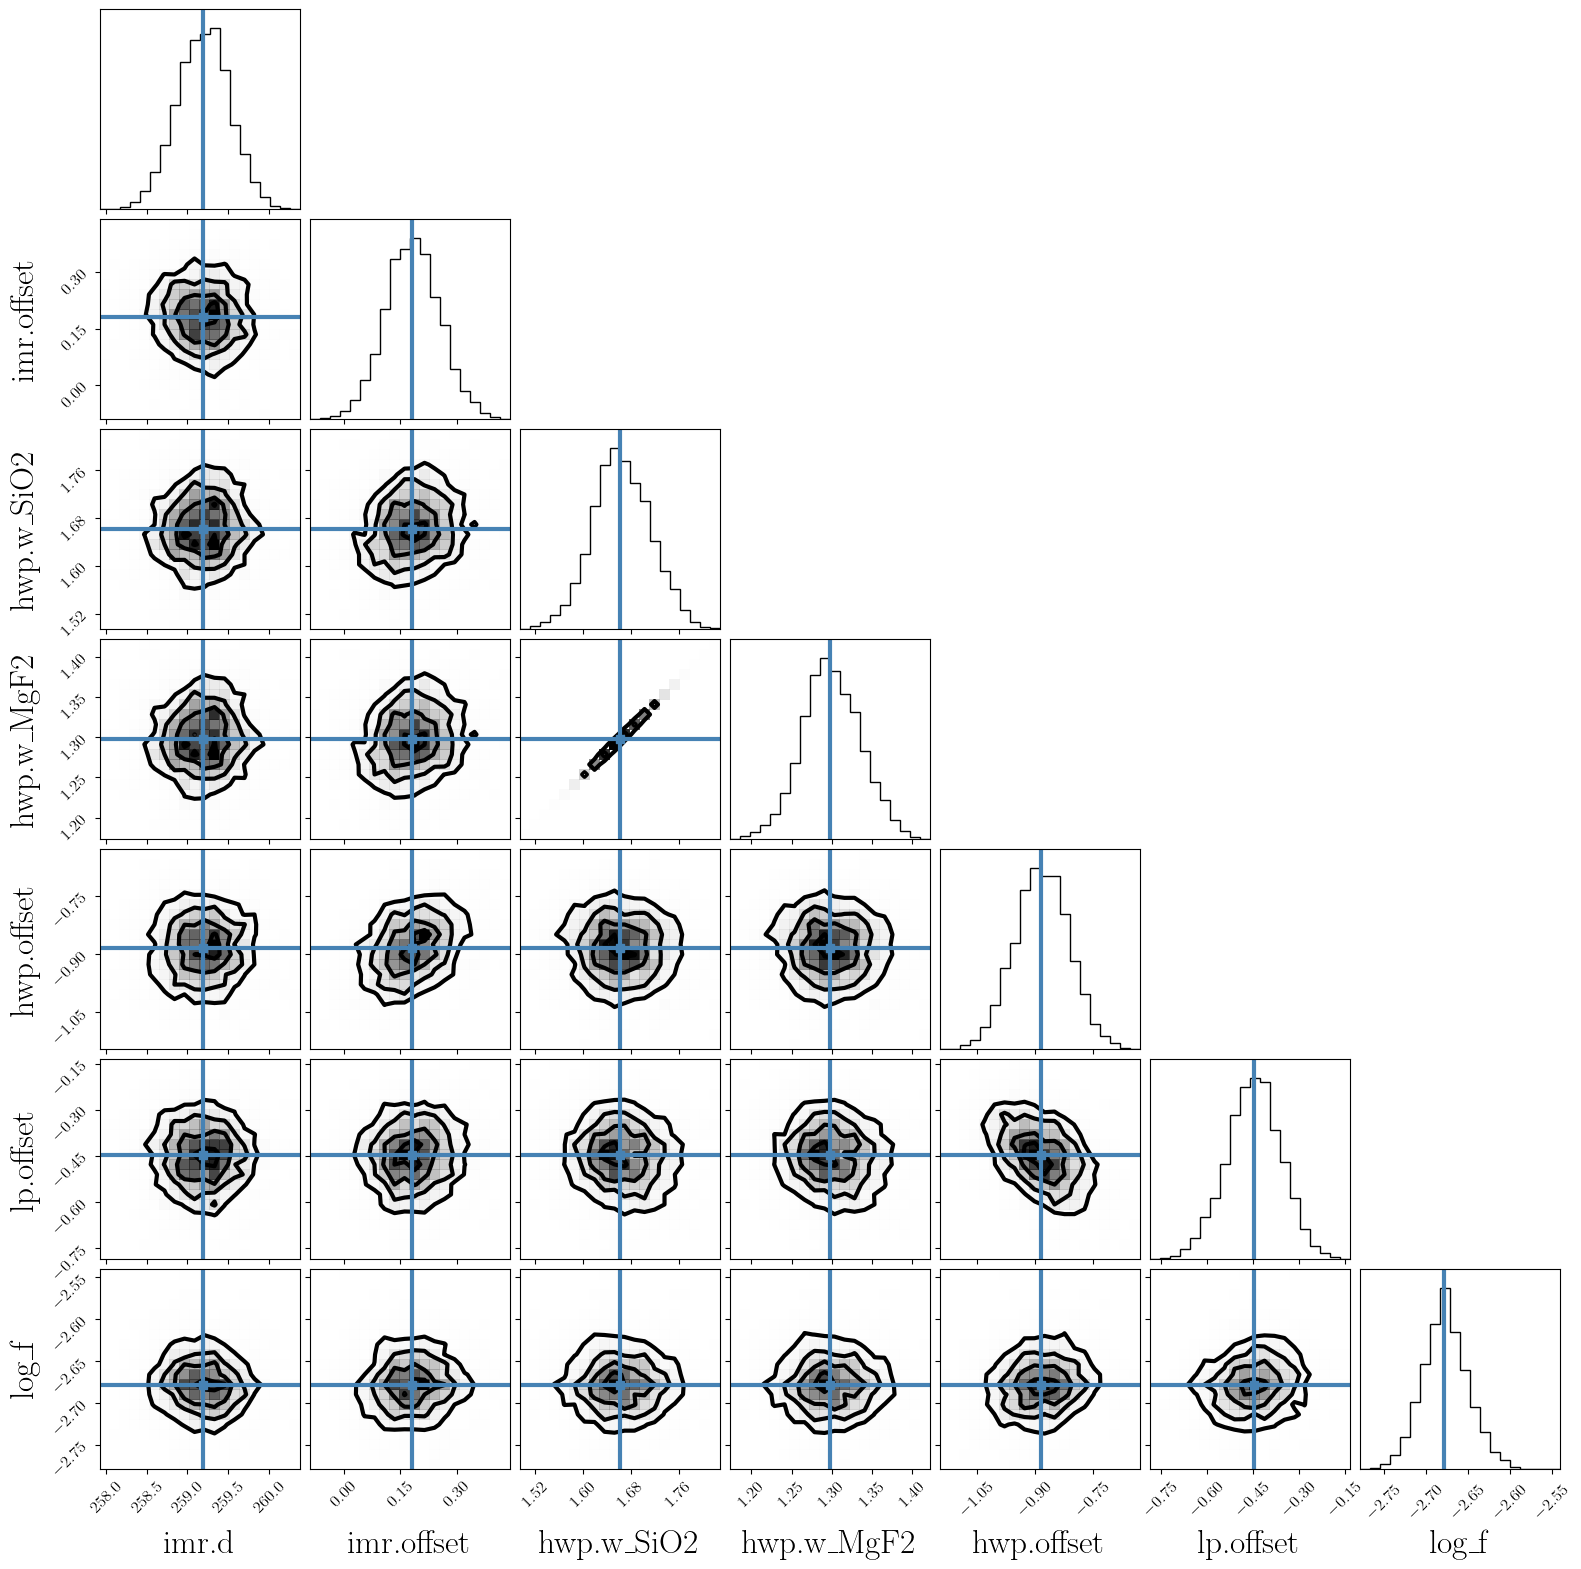

In [43]:
output_h5 = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/CHARIS/mcmc_output_larger_bounds_fixed_gaussian_smaller_dds.h5')
json_filepath = '/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/CHARIS/mcmcp0.json'
chain, names = load_chain_and_labels(output_h5, json_filepath, include_logf = True)
corner_plot_step_range = (2000,3000)
fig,ax = plot_corner_flat(chain, names, step_range=corner_plot_step_range)
print(chain.shape)
for ax in fig.get_axes():
    if ax.xaxis.label:  # check label exists
        ax.xaxis.label.set_fontsize(24)  # your desired size
    if ax.yaxis.label:
        ax.yaxis.label.set_fontsize(24)
#fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/cornerstd1.png',dpi=600,bbox_inches='tight')

In [46]:
inst.summarize_median_posterior(output_h5,p0_dict,step_range=(2000,3000))


Posterior Medians and 1 sigma Credible Intervals:
image_rotator,d: 259.19373 (+0.30813/-0.33269)
image_rotator,delta_theta: 0.18192 (+0.07269/-0.07018)
hwp,w_SiO2: 1.66228 (+0.05048/-0.04564)
hwp,w_MgF2: 1.29780 (+0.03772/-0.03393)
hwp,delta_theta: -0.88380 (+0.06913/-0.07024)
lprot,pa: -0.44743 (+0.08692/-0.08960)


{'d': {'median': 259.19373428823127,
  '-1sigma': 0.33269370681125565,
  '+1sigma': 0.30812596271681514},
 'delta_theta': {'median': -0.8838048619553576,
  '-1sigma': 0.07024453674858866,
  '+1sigma': 0.06912950200120771},
 'w_SiO2': {'median': 1.662277611079054,
  '-1sigma': 0.04564190466433127,
  '+1sigma': 0.050482954736568164},
 'w_MgF2': {'median': 1.2977968860508116,
  '-1sigma': 0.03393002089454278,
  '+1sigma': 0.03771504935638559},
 'pa': {'median': -0.4474328162280142,
  '-1sigma': 0.0896046291371822,
  '+1sigma': 0.08691910912537248}}

In [25]:
import numpy as np
import emcee

def get_map_from_emcee_h5(h5_path, discard=0, thin=1, var_names=None):
    """
    Return the MAP (maximum a posteriori) parameter vector from an emcee HDF5 backend.

    Parameters
    ----------
    h5_path : str or Path
        Path to the emcee .h5 file (created with emcee.backends.HDFBackend).
    discard : int, optional
        Number of initial steps to discard as burn-in (default 0).
    thin : int, optional
        Thinning factor (default 1).
    var_names : list[str], optional
        Optional list of parameter names; if provided and matches ndim,
        a dict of {name: value} is returned alongside the array.

    Returns
    -------
    map_params : np.ndarray
        The parameter vector at the maximum posterior sample (shape: [ndim]).
    info : dict
        Metadata with keys:
          - 'logp': MAP log-posterior value
          - 'step': step index (after discard/thin)
          - 'walker': walker index
          - 'flat_index': index in flattened chain
          - 'mapping' (optional): dict of {var_name: value} if var_names given
    """
    backend = emcee.backends.HDFBackend(h5_path)

    # Get chains & logp with original (step, walker, dim) shapes
    chain = backend.get_chain(discard=discard, thin=thin, flat=False)      # (nsteps, nwalkers, ndim)
    logp  = backend.get_log_prob(discard=discard, thin=thin, flat=False)   # (nsteps, nwalkers)

    # Handle any NaNs by treating them as -inf
    logp_safe = np.where(np.isfinite(logp), logp, -np.inf)

    # Locate MAP sample
    imax = np.nanargmax(logp_safe)
    step_idx, walker_idx = np.unravel_index(imax, logp_safe.shape)

    map_params = chain[step_idx, walker_idx, :].copy()
    map_logp   = float(logp_safe[step_idx, walker_idx])

    # Also compute flat index if you care
    nsteps, nwalkers = logp_safe.shape
    flat_index = step_idx * nwalkers + walker_idx

    info = {
        "logp": map_logp,
        "step": int(step_idx),
        "walker": int(walker_idx),
        "flat_index": int(flat_index),
    }

    if var_names is not None and len(var_names) == map_params.shape[0]:
        info["mapping"] = dict(zip(var_names, map_params))

    return map_params, info


In [44]:
get_map_from_emcee_h5(output_h5,1000,var_names=['d','imr_offset','wsio2','mgf2','hwp_offset','lp_offset','logf'])

(array([ 2.59167366e+02,  1.64272128e-01,  1.67749446e+00,  1.30912054e+00,
        -8.80778355e-01, -4.64374498e-01, -2.67704783e+00]),
 {'logp': 1484.58642578125,
  'step': 271,
  'walker': 19,
  'flat_index': 6523,
  'mapping': {'d': 259.167366126782,
   'imr_offset': 0.16427212764906346,
   'wsio2': 1.6774944640456533,
   'mgf2': 1.3091205356138493,
   'hwp_offset': -0.8807783547882065,
   'lp_offset': -0.46437449822734095,
   'logf': -2.677047828103286}})